"Due to limited computational resources, GridSearch, RandomizedSearchCV, and ADASYN without chunking could not be implemented, which may negatively impact the robustness and accuracy of the results."

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [7]:
# Importing data

data = pd.read_csv("/Users/anani/OneDrive - Old/Desktop/Red Ventures case/_28For_Candidate_29_dspm_case_data_set_-__28For_Candidate_29_dspm_case_data_set.csv")

df = pd.DataFrame(data)

In [8]:
df.head()

,userId,sessionReferrer,browser,deviceType,estimatedAnnualIncome,estimatedPropertyType,visitCount,pageURL,ctaCopy,ctaPlacement,editorialSnippet,scrolledPage,scrollDepth,clickedCTA,scheduledAppointment,revenue,mortgageVariation
0,user_97048,Google,Safari,Mobile,152000,Apartment,1,https://www.financialservices.com/mortgages/ty...,First Time? We've Made it Easy to Find the Bes...,Middle,"Understand the pros and cons of fixed-rate, ad...",1,75,0,0,0,NaN
1,user_14393,Social,Safari,Mobile,140000,Apartment,2,https://www.financialservices.com/mortgages/ho...,Access Your Personalized Mortgage Rates Now,Bottom,Equip yourself with knowledge. Understand the ...,1,25,0,0,0,NaN
2,user_30959,Direct,Safari,Mobile,128000,House,1,https://www.financialservices.com/mortgages/fi...,Access Your Personalized Mortgage Rates Now,Bottom,Navigate the home buying journey with confiden...,1,75,0,0,0,NaN
3,user_88588,Google,Chrome,Mobile,205000,Apartment,1,https://www.financialservices.com/mortgages/re...,Get Pre-Approved for a Mortgage in 5 Minutes,Middle,Our tools help you assess whether refinancing ...,1,75,1,0,0,NaN
4,user_65965,Google,Safari,Mobile,373000,House,1,https://www.financialservices.com/mortgages/re...,Access Your Personalized Mortgage Rates Now,Top,Navigate the complexities of mortgage rates wi...,0,0,0,0,0,NaN


### Exploratory Data Analysis

In [9]:

# How many null values are there
df.isna().sum()

# calculating the percentage of missing values in mortgagevariation
percent_missing_val=df['mortgageVariation'].isna().sum()/len(df)



Distribution of clickedCTA:
clickedCTA
0    82.739
1    17.261
Name: proportion, dtype: float64


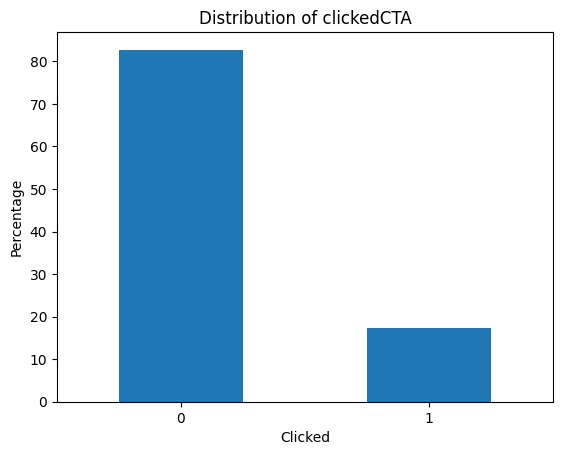

Distribution of scheduledAppointment:
scheduledAppointment
0    94.483
1     5.517
Name: proportion, dtype: float64


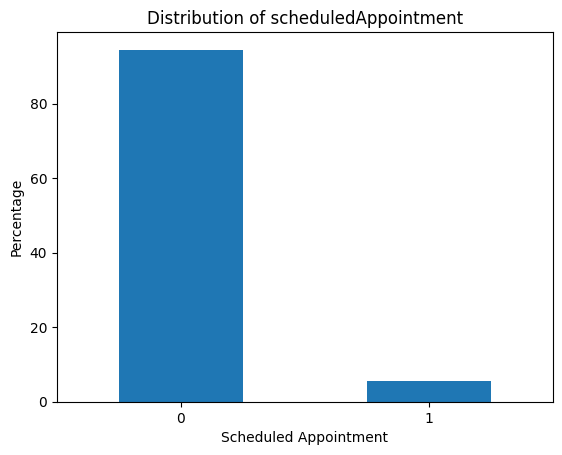

In [10]:
# Check distribution for `clickedCTA`
clicked_distribution = df['clickedCTA'].value_counts(normalize=True) * 100
print("Distribution of clickedCTA:")
print(clicked_distribution)

# Visualize `clickedCTA`
clicked_distribution.plot(kind='bar', title="Distribution of clickedCTA", rot=0)
plt.xlabel("Clicked")
plt.ylabel("Percentage")
plt.show()

# Check distribution for `scheduledAppointment`
appointment_distribution = df['scheduledAppointment'].value_counts(normalize=True) * 100
print("Distribution of scheduledAppointment:")
print(appointment_distribution)

# Visualize `scheduledAppointment`
appointment_distribution.plot(kind='bar', title="Distribution of scheduledAppointment", rot=0)
plt.xlabel("Scheduled Appointment")
plt.ylabel("Percentage")
plt.show()

There is an imbalance in the number of individuals who scheduled an appointment, which poses challenges for training the model effectively. To address this, Adaptive Synthetic Sampling (ADASYN) will be employed to generate synthetic samples and balance the dataset.

Key metrics before applying ADASYN method 

In [11]:
# Combine CTA Copy and Placement
df['CTA_Combination'] = df['ctaCopy'] + "_" + df['ctaPlacement']

# Summarize metrics
summary = df.groupby('CTA_Combination').agg(
    CTR=('clickedCTA', lambda x: x.mean() * 100),  # Click-Through Rate as percentage
    Form_Completion_Rate=('scheduledAppointment', lambda x: x.mean() * 100),  # Form Completion Rate
    Revenue_Per_Decision=('revenue', 'mean'),  # Average Revenue
    Total_Revenue=('revenue', 'sum'),  # Total Revenue
    Total_Decisions=('CTA_Combination', 'size')  # Total number of rows/decisions
).reset_index()

# Sort by Revenue Per Decision for ranking
summary = summary.sort_values(by='Revenue_Per_Decision', ascending=False)

summary

,CTA_Combination,CTR,Form_Completion_Rate,Revenue_Per_Decision,Total_Revenue,Total_Decisions
3,First Time? We've Made it Easy to Find the Bes...,15.309153,5.688057,12.905229,143390,11111
8,Get Pre-Approved for a Mortgage in 5 Minutes_Top,21.175306,6.029518,12.680886,140910,11112
5,First Time? We've Made it Easy to Find the Bes...,19.845198,5.454055,12.286923,136520,11111
2,Access Your Personalized Mortgage Rates Now_Top,18.648186,5.463055,12.120871,134675,11111
4,First Time? We've Made it Easy to Find the Bes...,16.992170,5.319053,12.071371,134125,11111
7,Get Pre-Approved for a Mortgage in 5 Minutes_M...,18.333183,5.787058,11.753668,130595,11111
6,Get Pre-Approved for a Mortgage in 5 Minutes_B...,15.417154,5.670057,11.697417,129970,11111
1,Access Your Personalized Mortgage Rates Now_Mi...,16.146161,5.067051,11.424264,126935,11111
0,Access Your Personalized Mortgage Rates Now_Bo...,13.482135,5.175052,11.332463,125915,11111


Distribution for deviceType:
deviceType
Mobile     60.034
Desktop    39.966
Name: proportion, dtype: float64



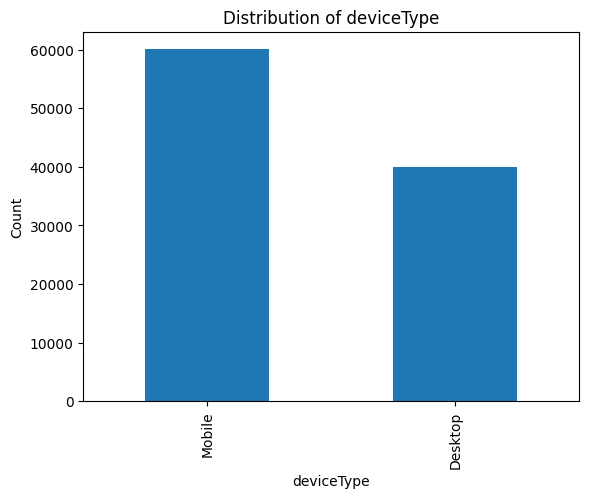

Distribution for browser:
browser
Safari     47.976
Chrome     41.108
Firefox     7.930
Edge        2.986
Name: proportion, dtype: float64



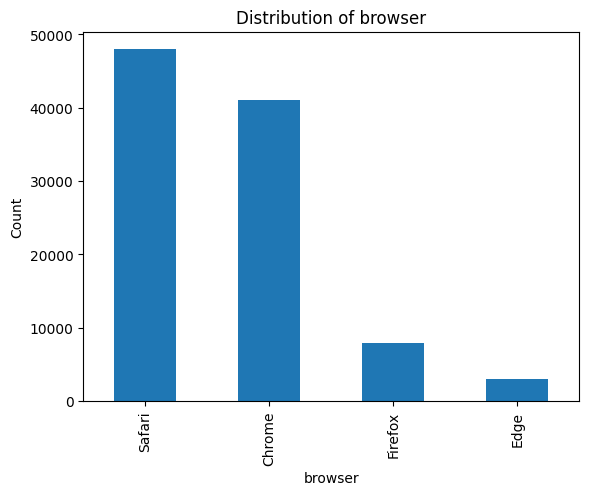

Statistics for estimatedAnnualIncome:
count    100000.000000
mean     130654.720000
std       62345.748304
min       50000.000000
25%       90000.000000
50%      117000.000000
75%      145000.000000
max      400000.000000
Name: estimatedAnnualIncome, dtype: float64



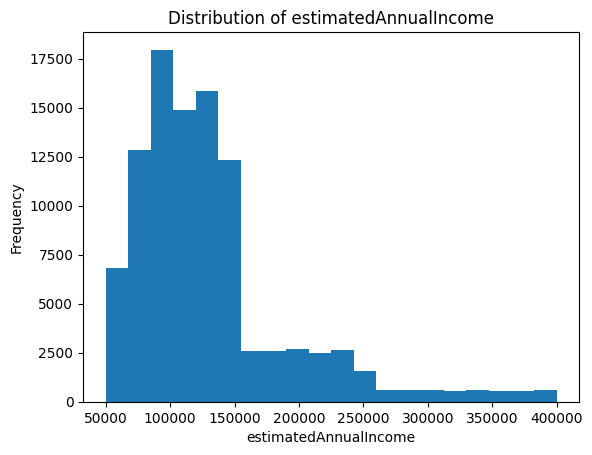

Statistics for visitCount:
count    100000.000000
mean          2.225850
std           2.070924
min           1.000000
25%           1.000000
50%           1.000000
75%           3.000000
max          10.000000
Name: visitCount, dtype: float64



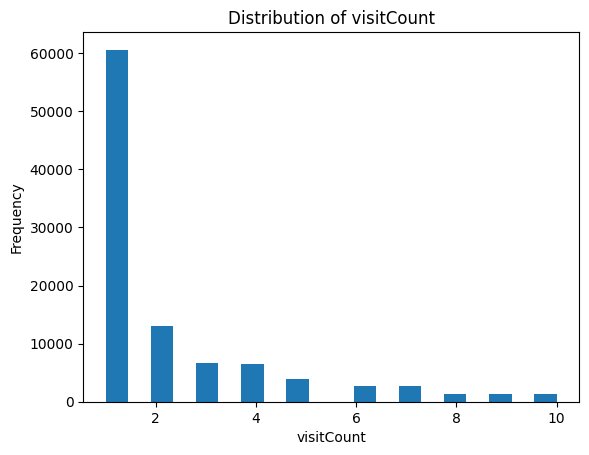

In [12]:
# Check distribution for categorical attributes
for col in ['deviceType', 'browser']:
    print(f"Distribution for {col}:")
    print(df[col].value_counts(normalize=True) * 100)  # Percentage distribution
    print()

    # Visualize the distribution
    df[col].value_counts().plot(kind='bar', title=f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.show()

# Check distribution for numerical attributes
for col in ['estimatedAnnualIncome', 'visitCount']:
    print(f"Statistics for {col}:")
    print(df[col].describe())  # Summary statistics
    print()

    # Visualize the distribution
    df[col].plot(kind='hist', bins=20, title=f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()##

Due to the requirement for a large memory capacity, the process will be executed using a chunk size of 1000 to optimize resource usage.

Testing Performace of each combiantion using ANOVA

In [13]:
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import statsmodels.api as sm

# One-Way ANOVA (Testing mean differences between CTA_Combination)
model_one_way = ols('clickedCTA ~ C(CTA_Combination)', data=df).fit()
anova_one_way = anova_lm(model_one_way)

print("One-Way ANOVA Results (CTA_Combination):")
print(anova_one_way)

One-Way ANOVA Results (CTA_Combination):
                         df        sum_sq   mean_sq         F        PR(>F)
C(CTA_Combination)      8.0     53.198963  6.649870  46.73246  1.018252e-75
Residual            99991.0  14228.379827  0.142297       NaN           NaN


                                                              Multiple Comparison of Means - Tukey HSD, FWER=0.05                                                               
                               group1                                                               group2                                meandiff p-adj   lower   upper  reject
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
                  Access Your Personalized Mortgage Rates Now_Bottom                   Access Your Personalized Mortgage Rates Now_Middle   0.0266    0.0  0.0109  0.0423   True
                  Access Your Personalized Mortgage Rates Now_Bottom                      Access Your Personalized Mortgage Rates Now_Top   0.0517    0.0   0.036  0.0674   True
                  Access Your Personalized Mortgage Rates Now_Bottom First Time? We've Made it Easy to Find the Bes

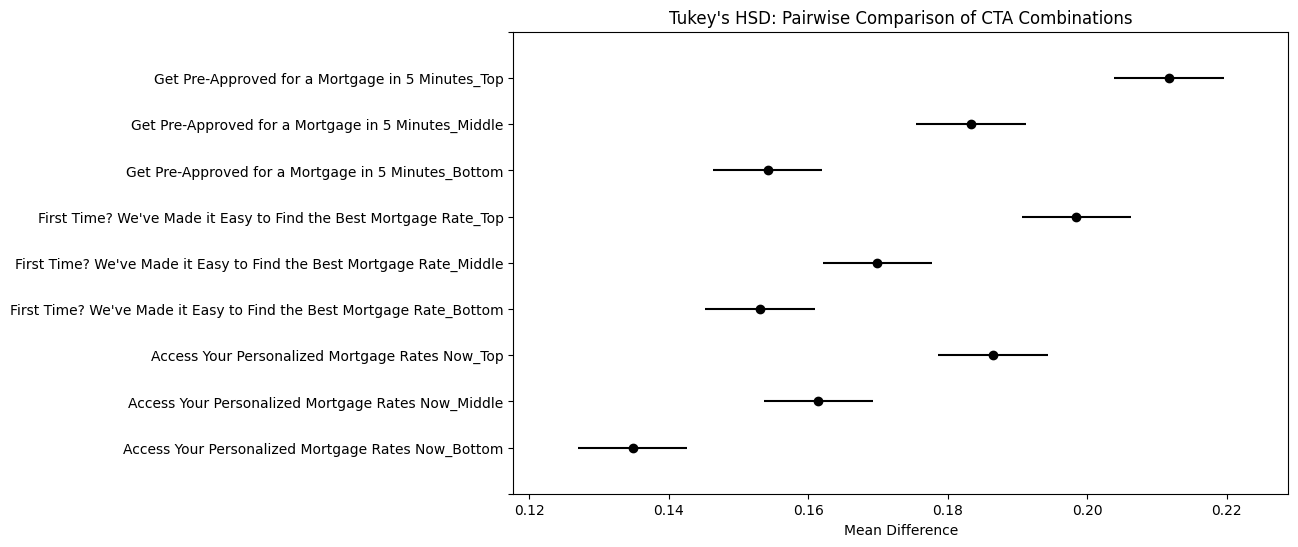

In [14]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import pandas as pd

# Assuming `df` is your DataFrame with relevant columns

# Perform Tukey's HSD test
tukey = pairwise_tukeyhsd(
    endog=df['clickedCTA'],  # The dependent variable (performance metric)
    groups=df['CTA_Combination'],  # The independent variable (grouping by combinations)
    alpha=0.05  # Significance level
)

# Print results
print(tukey)

# Optional: Visualize the results
tukey.plot_simultaneous()
plt.title("Tukey's HSD: Pairwise Comparison of CTA Combinations")
plt.xlabel("Mean Difference")
plt.show()

In [15]:
#Two-Way ANOVA (Testing interaction effects between ctaCopy and ctaPlacement)
model_two_way = ols('clickedCTA ~ C(ctaCopy) * C(ctaPlacement)', data=df).fit()
anova_two_way = anova_lm(model_two_way)

print("\nTwo-Way ANOVA Results (ctaCopy and ctaPlacement Interaction):")
print(anova_two_way) 



Two-Way ANOVA Results (ctaCopy and ctaPlacement Interaction):
                                 df        sum_sq    mean_sq           F  \
C(ctaCopy)                      2.0      8.261376   4.130688   29.028716   
C(ctaPlacement)                 2.0     44.317066  22.158533  155.720743   
C(ctaCopy):C(ctaPlacement)      4.0      0.620521   0.155130    1.090190   
Residual                    99991.0  14228.379827   0.142297         NaN   

                                  PR(>F)  
C(ctaCopy)                  2.492569e-13  
C(ctaPlacement)             2.995322e-68  
C(ctaCopy):C(ctaPlacement)  3.593846e-01  
Residual                             NaN  


Tukey's HSD for ctaCopy:
                                                      Multiple Comparison of Means - Tukey HSD, FWER=0.05                                                       
                            group1                                                        group2                            meandiff p-adj  lower  upper  reject
----------------------------------------------------------------------------------------------------------------------------------------------------------------
                  Access Your Personalized Mortgage Rates Now First Time? We've Made it Easy to Find the Best Mortgage Rate   0.0129    0.0  0.006 0.0198   True
                  Access Your Personalized Mortgage Rates Now                  Get Pre-Approved for a Mortgage in 5 Minutes   0.0222    0.0 0.0153  0.029   True
First Time? We've Made it Easy to Find the Best Mortgage Rate                  Get Pre-Approved for a Mortgage in 5 Minutes   0.0093 0.0044 0.0024 0.0161   True
---------

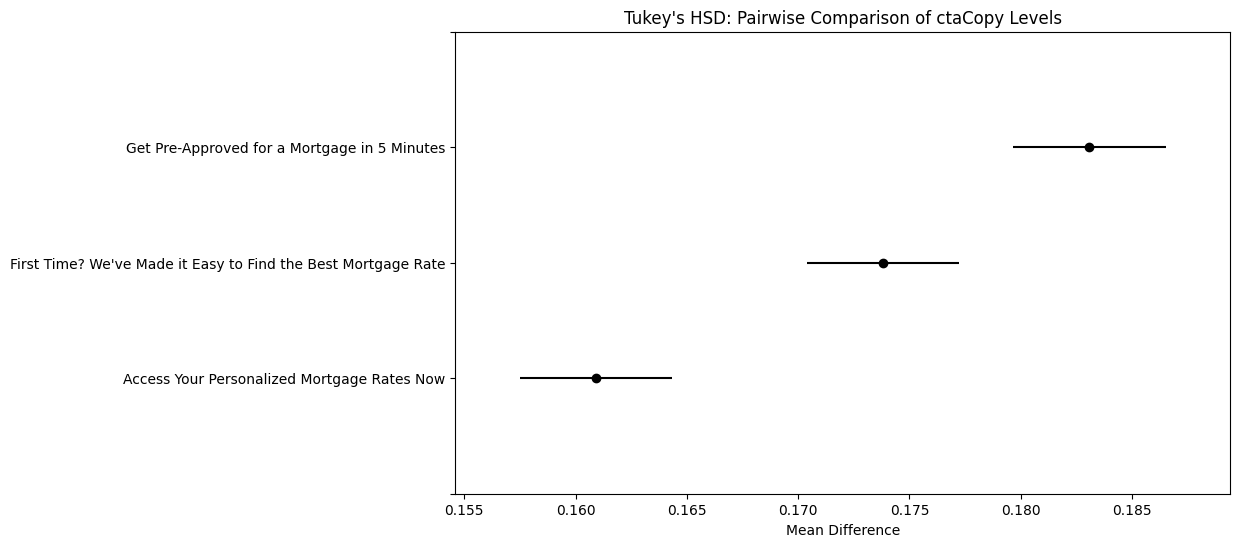


Tukey's HSD for ctaPlacement:
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj lower  upper  reject
-------------------------------------------------
Bottom Middle   0.0242   0.0 0.0174 0.0311   True
Bottom    Top   0.0515   0.0 0.0447 0.0584   True
Middle    Top   0.0273   0.0 0.0205 0.0342   True
-------------------------------------------------


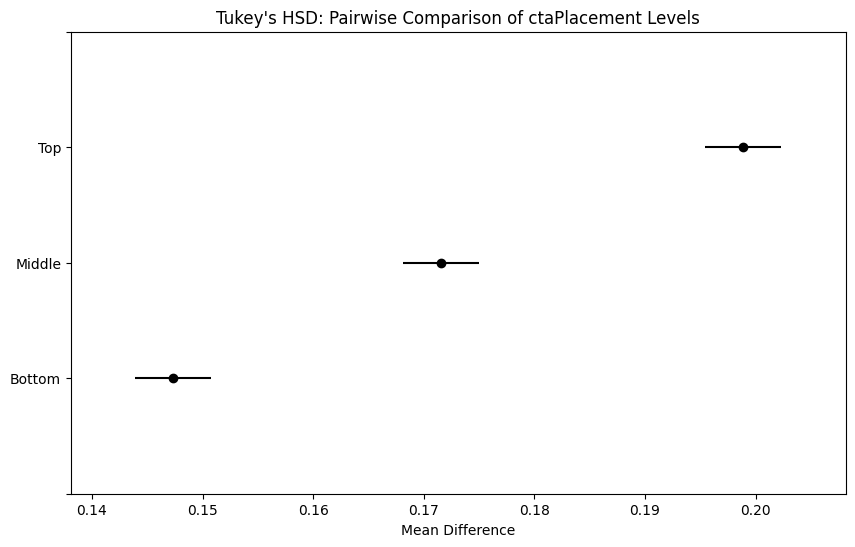

In [16]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import matplotlib.pyplot as plt

# Tukey's HSD for ctaCopy
tukey_ctaCopy = pairwise_tukeyhsd(
    endog=df['clickedCTA'],        # The dependent variable
    groups=df['ctaCopy'],          # The independent variable (ctaCopy levels)
    alpha=0.05                     # Significance level
)
print("Tukey's HSD for ctaCopy:")
print(tukey_ctaCopy)

# Plot Tukey's HSD results for ctaCopy
tukey_ctaCopy.plot_simultaneous()
plt.title("Tukey's HSD: Pairwise Comparison of ctaCopy Levels")
plt.xlabel("Mean Difference")
plt.show()

# Tukey's HSD for ctaPlacement
tukey_ctaPlacement = pairwise_tukeyhsd(
    endog=df['clickedCTA'],         # The dependent variable
    groups=df['ctaPlacement'],      # The independent variable (ctaPlacement levels)
    alpha=0.05                      # Significance level
)
print("\nTukey's HSD for ctaPlacement:")
print(tukey_ctaPlacement)

# Plot Tukey's HSD results for ctaPlacement
tukey_ctaPlacement.plot_simultaneous()
plt.title("Tukey's HSD: Pairwise Comparison of ctaPlacement Levels")
plt.xlabel("Mean Difference")
plt.show()


### Customer Segmentation 

In [17]:
df.dtypes

userId                   object
sessionReferrer          object
browser                  object
deviceType               object
estimatedAnnualIncome     int64
estimatedPropertyType    object
visitCount                int64
pageURL                  object
ctaCopy                  object
ctaPlacement             object
editorialSnippet         object
scrolledPage              int64
scrollDepth               int64
clickedCTA                int64
scheduledAppointment      int64
revenue                   int64
mortgageVariation        object
CTA_Combination          object
dtype: object

In [18]:
from imblearn.over_sampling import ADASYN
from sklearn.model_selection import train_test_split
import pandas as pd

# Step 1: Split data into smaller chunks
chunk_size = 1000
chunks = [df[i:i + chunk_size] for i in range(0, len(df), chunk_size)]

adasyn = ADASYN(sampling_strategy='minority', random_state=42, n_neighbors=5)

for i, chunk in enumerate(chunks):
    # Step 2: Prepare data for ADASYN
    X_chunk = chunk.drop(columns=['scheduledAppointment'])
    y_chunk = chunk['scheduledAppointment']

    # Encode categorical variables
    X_chunk = pd.get_dummies(X_chunk, drop_first=True)

    # Split into training and testing sets
    X_train, _, y_train, _ = train_test_split(
        X_chunk, y_chunk, test_size=0.2, random_state=42
    )

    # Apply ADASYN
    X_resampled, y_resampled = adasyn.fit_resample(X_train, y_train)

    print(f"Processed chunk {i + 1}/{len(chunks)}")
    print("Original distribution:", y_train.value_counts().to_dict())
    print("Resampled distribution:", pd.Series(y_resampled).value_counts().to_dict())


Processed chunk 1/100
Original distribution: {0: 763, 1: 37}
Resampled distribution: {1: 766, 0: 763}
Processed chunk 2/100
Original distribution: {0: 749, 1: 51}
Resampled distribution: {0: 749, 1: 735}
Processed chunk 3/100
Original distribution: {0: 759, 1: 41}
Resampled distribution: {1: 772, 0: 759}
Processed chunk 4/100
Original distribution: {0: 759, 1: 41}
Resampled distribution: {1: 773, 0: 759}
Processed chunk 5/100
Original distribution: {0: 760, 1: 40}
Resampled distribution: {1: 776, 0: 760}
Processed chunk 6/100
Original distribution: {0: 760, 1: 40}
Resampled distribution: {1: 772, 0: 760}
Processed chunk 7/100
Original distribution: {0: 756, 1: 44}
Resampled distribution: {1: 756, 0: 756}
Processed chunk 8/100
Original distribution: {0: 755, 1: 45}
Resampled distribution: {0: 755, 1: 746}
Processed chunk 9/100
Original distribution: {0: 759, 1: 41}
Resampled distribution: {0: 759, 1: 751}
Processed chunk 10/100
Original distribution: {0: 757, 1: 43}
Resampled distributi

In [19]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import silhouette_score


# Select features for clustering
features = ['deviceType', 'visitCount', 'ctaPlacement', 'ctaCopy','sessionReferrer','browser','estimatedAnnualIncome',
            'estimatedPropertyType', 'editorialSnippet', 'scrolledPage', 'scheduledAppointment',]

# Preprocess data: Encode categorical variables and scale numerical ones
categorical_features = ['deviceType', 'ctaPlacement', 'ctaCopy']
numerical_features = ['estimatedAnnualIncome', 'visitCount']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ]
)

# Apply KMeans
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('kmeans', KMeans(n_clusters=3, random_state=42))  # Adjust n_clusters as needed
])

# Fit the pipeline
pipeline.fit(df[features])

# Assign clusters to users
df['Cluster'] = pipeline.named_steps['kmeans'].labels_

# Analyze performance metrics within each cluster
cluster_metrics = df.groupby('Cluster').agg(
    CTR=('clickedCTA', 'mean'),
    Form_Completion_Rate=('scheduledAppointment', 'mean'),
    Revenue_Per_User=('revenue', 'mean'),
    Total_Users=('userId', 'count')
).reset_index()

print(cluster_metrics)

   Cluster       CTR  Form_Completion_Rate  Revenue_Per_User  Total_Users
0        0  0.150319              0.047620         10.377288        52016
1        1  0.172186              0.058196         12.464894        13317
2        2  0.206219              0.065336         14.343756        34667


### Using Elbow Method and Silhouette to determine how many clusters to create

**Caution:** Running this code may require substantial computational resources. It has caused my computer to crash twice and takes approximately 1 hour to complete execution.

In [20]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import pandas as pd

# Define features for clustering
features = [
    'deviceType', 'visitCount', 'ctaPlacement', 'ctaCopy', 'sessionReferrer',
    'browser', 'estimatedAnnualIncome', 'estimatedPropertyType', 
    'editorialSnippet', 'scrolledPage', 'scheduledAppointment'
]

# Preprocess data: Encode categorical variables and scale numerical ones
categorical_features = [
    'deviceType', 'ctaPlacement', 'ctaCopy', 'sessionReferrer',
    'browser', 'estimatedPropertyType', 'editorialSnippet'
]
numerical_features = ['estimatedAnnualIncome', 'visitCount', 'scrolledPage', 'scheduledAppointment']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),  # Scale numerical features
        ('cat', OneHotEncoder(), categorical_features)  # Encode categorical features
    ]
)

# Elbow Method and Silhouette Score Analysis
inertia = []  # To store the SSE (sum of squared errors)
silhouette_scores = []  # To store the silhouette scores
K = range(2, 11)  # Test for k from 2 to 10 clusters

for k in K:
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('kmeans', KMeans(n_clusters=k, random_state=42))
    ])
    
    # Fit the pipeline
    pipeline.fit(df[features])
    
    # Inertia (SSE)
    inertia.append(pipeline.named_steps['kmeans'].inertia_)
    
    # Silhouette Score
    cluster_labels = pipeline.named_steps['kmeans'].labels_
    score = silhouette_score(
        pipeline.named_steps['preprocessor'].transform(df[features]),
        cluster_labels
    )
    silhouette_scores.append(score)

# Plot the Elbow Method
plt.figure(figsize=(10, 5))
plt.plot(K, inertia, 'bo-', label='SSE (Inertia)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('SSE (Inertia)')
plt.title('Elbow Method for Optimal k')
plt.legend()
plt.show()

# Plot the Silhouette Scores
plt.figure(figsize=(10, 5))
plt.plot(K, silhouette_scores, 'ro-', label='Silhouette Score')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for Optimal k')
plt.legend()
plt.show()


"\nfrom sklearn.cluster import KMeans\nfrom sklearn.preprocessing import StandardScaler, OneHotEncoder\nfrom sklearn.compose import ColumnTransformer\nfrom sklearn.pipeline import Pipeline\nfrom sklearn.metrics import silhouette_score\nimport matplotlib.pyplot as plt\nimport pandas as pd\n\n# Define features for clustering\nfeatures = [\n    'deviceType', 'visitCount', 'ctaPlacement', 'ctaCopy', 'sessionReferrer',\n    'browser', 'estimatedAnnualIncome', 'estimatedPropertyType', \n    'editorialSnippet', 'scrolledPage', 'scheduledAppointment'\n]\n\n# Preprocess data: Encode categorical variables and scale numerical ones\ncategorical_features = [\n    'deviceType', 'ctaPlacement', 'ctaCopy', 'sessionReferrer',\n    'browser', 'estimatedPropertyType', 'editorialSnippet'\n]\nnumerical_features = ['estimatedAnnualIncome', 'visitCount', 'scrolledPage', 'scheduledAppointment']\n\npreprocessor = ColumnTransformer(\n    transformers=[\n        ('num', StandardScaler(), numerical_features),  # 

### Clustering with updated k =4

In [21]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import pandas as pd

# Define features for clustering
features = ['estimatedAnnualIncome', 'scrollDepth', 'visitCount', 'deviceType', 'browser']

# Preprocessing pipeline for specified features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['estimatedAnnualIncome', 'scrollDepth', 'visitCount']),  # Scale numerical features
        ('cat', OneHotEncoder(), ['deviceType', 'browser'])  # Encode categorical features
    ]
)

# K-Means pipeline with k = 4 clusters
kmeans_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('kmeans', KMeans(n_clusters=4, random_state=42))
])

# Fit the pipeline to the data
kmeans_pipeline.fit(df[features])

# Assign clusters to users
df['Cluster'] = kmeans_pipeline.named_steps['kmeans'].labels_

# Analyze performance metrics within each cluster
cluster_metrics = df.groupby('Cluster').agg(
    CTR=('clickedCTA', 'mean'),  # Click-through rate
    Form_Completion_Rate=('scheduledAppointment', 'mean'),  # Appointment scheduling rate
    Revenue_Per_User=('revenue', 'mean'),  # Average revenue per user
    Total_Users=('userId', 'count')  # Total users in each cluster
).reset_index()

print(cluster_metrics)


   Cluster       CTR  Form_Completion_Rate  Revenue_Per_User  Total_Users
0        0  0.070151              0.019229          4.035429        25431
1        1  0.220371              0.070680         14.700598        50651
2        2  0.180916              0.061791         12.914250        11895
3        3  0.179905              0.059303         16.817350        12023


### K-means Clusetering k=5

In [22]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import pandas as pd

# Define features for clustering
features = ['estimatedAnnualIncome', 'scrollDepth', 'visitCount', 'deviceType', 'browser']

# Preprocessing pipeline for specified features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['estimatedAnnualIncome', 'scrollDepth', 'visitCount']),  # Scale numerical features
        ('cat', OneHotEncoder(), ['deviceType', 'browser'])  # Encode categorical features
    ]
)

# K-Means pipeline with k = 5 clusters
kmeans_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('kmeans', KMeans(n_clusters=5, random_state=42))
])

# Fit the pipeline to the data
kmeans_pipeline.fit(df[features])

# Assign clusters to users
df['Cluster'] = kmeans_pipeline.named_steps['kmeans'].labels_

# Analyze performance metrics within each cluster
cluster_metrics = df.groupby('Cluster').agg(
    CTR=('clickedCTA', 'mean'),  # Click-through rate
    Form_Completion_Rate=('scheduledAppointment', 'mean'),  # Appointment scheduling rate
    Revenue_Per_User=('revenue', 'mean'),  # Average revenue per user
    Total_Users=('userId', 'count')  # Total users in each cluster
).reset_index()

print(cluster_metrics)


   Cluster       CTR  Form_Completion_Rate  Revenue_Per_User  Total_Users
0        0  0.068166              0.018838          3.949495        24631
1        1  0.212454              0.067772         14.102901        43440
2        2  0.148702              0.050092         10.726462         7626
3        3  0.179782              0.058869         16.740753        11653
4        4  0.246957              0.082292         17.094466        12650


In [23]:
# Assuming you have a fitted pipeline with KMeans
cluster_assignments = pipeline.named_steps['kmeans'].labels_

# Add the cluster assignments to the original DataFrame
df['Cluster'] = cluster_assignments



### Profiling clusters 

   Cluster       CTR  Total_Users
0        0  0.150319        52016
1        1  0.172186        13317
2        2  0.206219        34667


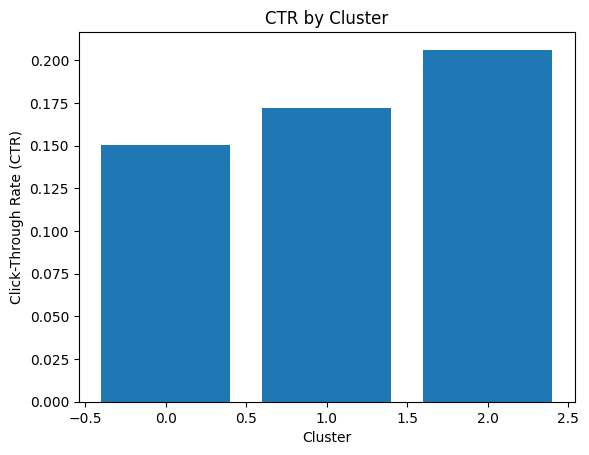

In [24]:
# Calculate Click-Through Rate (CTR) for each cluster
cluster_click_analysis = df.groupby('Cluster').agg(
    CTR=('clickedCTA', 'mean'),  # Percentage of users who clicked the banner
    Total_Users=('userId', 'count')  # Total number of users in each cluster
).reset_index()

# Display the CTR for each cluster
print(cluster_click_analysis)

# Visualize CTRs
import matplotlib.pyplot as plt

plt.bar(cluster_click_analysis['Cluster'], cluster_click_analysis['CTR'])
plt.xlabel('Cluster')
plt.ylabel('Click-Through Rate (CTR)')
plt.title('CTR by Cluster')
plt.show()


   Cluster  visitCount  Total_Users
0        0    1.523012        52016
1        1    6.783810        13317
2        2    1.529524        34667


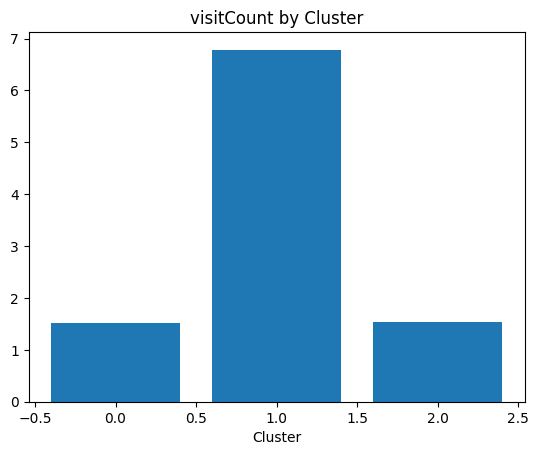

In [25]:
# Calculate Click-Through Rate (CTR) for each cluster
cluster_click_analysis = df.groupby('Cluster').agg(
    visitCount=('visitCount', 'mean'),  # Percentage of users who clicked the banner
    Total_Users=('userId', 'count')  # Total number of users in each cluster
).reset_index()

# Display the CTR for each cluster
print(cluster_click_analysis)

# Visualize CTRs
import matplotlib.pyplot as plt

plt.bar(cluster_click_analysis['Cluster'], cluster_click_analysis['visitCount'])
plt.xlabel('Cluster')
plt.title('visitCount by Cluster')
plt.show()


#### What combinations did each cluster see

In [26]:
# Calculate proportions of ctaCopy and ctaPlacement combinations within each cluster
cta_combination_analysis = df.groupby(['Cluster', 'ctaCopy', 'ctaPlacement']).size().reset_index(name='Count')

# Calculate proportions within each cluster
cta_combination_analysis['Proportion'] = cta_combination_analysis.groupby('Cluster')['Count'].transform(lambda x: x / x.sum())


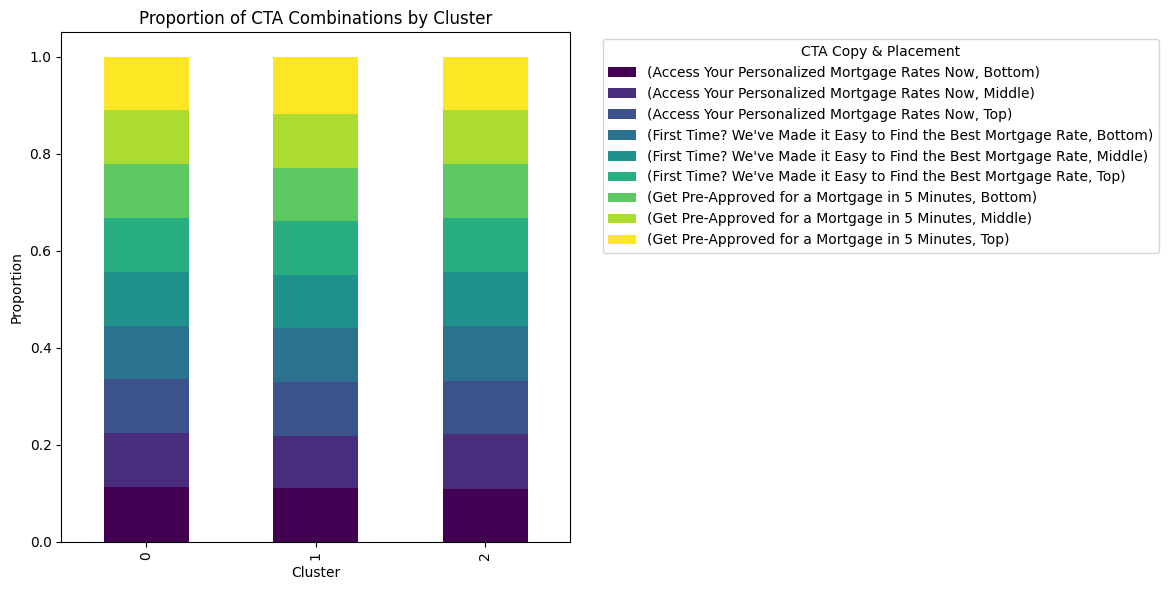

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

# Pivot data for visualization
cta_pivot = cta_combination_analysis.pivot_table(
    index='Cluster', 
    columns=['ctaCopy', 'ctaPlacement'], 
    values='Proportion', 
    fill_value=0
)

# Stacked bar chart
cta_pivot.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='viridis')
plt.title('Proportion of CTA Combinations by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Proportion')
plt.legend(title='CTA Copy & Placement', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


They all received the similar proportion of CTA combination

In [28]:
# Profile for numerical variables
numerical_vars = [
    'estimatedAnnualIncome', 'visitCount', 'scrollDepth', 'revenue'
]
categorical_vars = [
    'sessionReferrer', 'browser', 'deviceType', 'estimatedPropertyType',
    'ctaCopy', 'ctaPlacement', 'editorialSnippet', 'scrolledPage',
    'clickedCTA', 'scheduledAppointment', 'mortgageVariation'
]

# Summary statistics for numerical variables
numerical_profile = df.groupby('Cluster')[numerical_vars].agg(['mean', 'median'])

# Distribution of categorical variables
categorical_profile = {}
for var in categorical_vars:
    categorical_profile[var] = df.groupby('Cluster')[var].value_counts(normalize=True).unstack().fillna(0)

numerical_profile

estimatedAnnualIncome           visitCount        scrollDepth         \
                         mean    median       mean median        mean median   
Cluster                                                                        
0               130560.750538  117000.0   1.523012    1.0   57.676484   75.0   
1               130622.137118  117000.0   6.783810    6.0   61.877675   75.0   
2               130808.232613  116000.0   1.529524    1.0   69.279863   75.0   

           revenue         
              mean median  
Cluster                    
0        10.377288    0.0  
1        12.464894    0.0  
2        14.343756    0.0

In [29]:
categorical_profile

{'sessionReferrer': sessionReferrer    Direct     Email    Google    Social
 Cluster                                                
 0                0.171024  0.124404  0.613350  0.091222
 1                0.226628  0.418863  0.290906  0.063603
 2                0.168200  0.127326  0.612831  0.091643,
 'browser': browser    Chrome      Edge   Firefox    Safari
 Cluster                                        
 0        0.367810  0.004864  0.027107  0.600219
 1        0.413607  0.030187  0.081099  0.475107
 2        0.475034  0.067240  0.156922  0.300805,
 'deviceType': deviceType   Desktop    Mobile
 Cluster                       
 0           0.000000  1.000000
 1           0.397912  0.602088
 2           1.000000  0.000000,
 'estimatedPropertyType': estimatedPropertyType  Apartment     House  Mobile Home  Townhome
 Cluster                                                          
 0                       0.336473  0.528626     0.026011  0.108890
 1                       0.329128  0.

It seems that the device a user uses to access the website plays a significant role in their decision on whether to click the banner or not

1. Null Hypothesis (H₀): Device type does not affect the likelihood of clicking the banner.
2. Alternative Hypothesis (H₁): Device type affects the likelihood of clicking the banner.

In [30]:
# Calculate CTR for each device type
device_ctr = df.groupby('deviceType').agg(
    CTR=('clickedCTA', 'mean'),
    Total_Users=('userId', 'count')
).reset_index()

from scipy.stats import chi2_contingency

# Create a contingency table
contingency_table = pd.crosstab(df['deviceType'], df['clickedCTA'])

# Perform Chi-Square test
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-Square Statistic: {chi2}")
print(f"P-Value: {p}")

Chi-Square Statistic: 522.42956764655
P-Value: 1.253024678456721e-115


Since the p-value is much smaller than the commonly used threshold of 0.05, you can reject the null hypothesis. This means there is a statistically significant association between device type and the likelihood of clicking the banner.

### Predictive Model

In [31]:

#preprocessing 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Define input features and target variable
X = df[['deviceType', 'browser', 'estimatedAnnualIncome', 'visitCount', 'scrollDepth', 
        'ctaCopy', 'ctaPlacement', 'sessionReferrer']]
y = df['revenue']

# One-hot encode categorical variables and scale numerical variables
categorical_features = ['deviceType', 'browser', 'ctaCopy', 'ctaPlacement', 'sessionReferrer']
numerical_features = ['estimatedAnnualIncome', 'visitCount', 'scrollDepth']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ]
)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Cannot use GridSearch or RandomSearch to determine the optimal parameters

In [32]:
## gradient boosting
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Define and train the model
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', GradientBoostingRegressor(random_state=42))
])

model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R² Score: {r2}")


Mean Squared Error: 2757.252232253952
R² Score: 0.02584725836139301


In [33]:
import numpy as np
import pandas as pd

# Generate all possible combinations of ctaCopy and ctaPlacement
cta_combinations = df[['ctaCopy', 'ctaPlacement']].drop_duplicates()

# Predict revenue for each combination for a given user
def recommend_cta(user_features, model, cta_combinations):
    user_recommendations = []
    
    for _, row in cta_combinations.iterrows():
        # Update user features with the current CTA combination
        features = user_features.copy()
        features['ctaCopy'] = row['ctaCopy']
        features['ctaPlacement'] = row['ctaPlacement']
        
        # Convert the features to a DataFrame with one row
        features_df = pd.DataFrame([features])
        
        # Predict revenue
        predicted_revenue = model.predict(features_df)[0]
        
        user_recommendations.append((row['ctaCopy'], row['ctaPlacement'], predicted_revenue))
    
    # Return the combination with the highest predicted revenue
    return max(user_recommendations, key=lambda x: x[2])

# Example: Recommend for a single user
user_features = X_test.iloc[0].to_dict()  # Convert a single user's features to a dictionary
best_cta = recommend_cta(user_features, model, cta_combinations)
print(f"Recommended CTA: {best_cta}")


Recommended CTA: ('Get Pre-Approved for a Mortgage in 5 Minutes', 'Top', np.float64(11.456029908771663))


In [34]:
# Calculate average revenue for top-performing CTA from Part 1
top_cta_revenue = df[(df['ctaCopy'] == 'Top CTA Copy') & (df['ctaPlacement'] == 'Top Placement')]['revenue'].mean()

# Calculate average predicted revenue from the model
predicted_revenue = model.predict(X_test).mean()

# Compare revenue
revenue_increase = predicted_revenue - top_cta_revenue
print(f"Predicted Revenue Increase: {revenue_increase}")


Predicted Revenue Increase: nan


### Using a Random Forest

In [36]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# Define categorical and numerical features
categorical_features = ['deviceType', 'browser', 'ctaCopy', 'ctaPlacement', 'sessionReferrer']
numerical_features = ['estimatedAnnualIncome', 'visitCount', 'scrollDepth']

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),  # Scale numerical features
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)  # One-hot encode categorical features
    ]
)

# Define the Random Forest model pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(random_state=42))
])

# Define input features and target variable
X = df[['deviceType', 'browser', 'estimatedAnnualIncome', 'visitCount', 'scrollDepth', 
        'ctaCopy', 'ctaPlacement', 'sessionReferrer']]
y = df['revenue']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model using the pipeline
pipeline.fit(X_train, y_train)

# Predict on the test set
y_pred_rf = pipeline.predict(X_test)

# Evaluate the model
print("Random Forest MSE:", mean_squared_error(y_test, y_pred_rf))
print("Random Forest R²:", r2_score(y_test, y_pred_rf))


Random Forest MSE: 3326.6286516289742
Random Forest R²: -0.17531663715393941


In [41]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# Define categorical and numerical features
categorical_features = ['deviceType', 'browser', 'ctaCopy', 'ctaPlacement', 'sessionReferrer']
numerical_features = ['estimatedAnnualIncome', 'visitCount', 'scrollDepth']

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),  # Scale numerical features
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)  # One-hot encode categorical features
    ]
)

# Define the Random Forest model pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(n_estimators= 100, max_depth= 10 ,random_state=42))
])

# Define input features and target variable
X = df[['deviceType', 'browser', 'estimatedAnnualIncome', 'visitCount', 'scrollDepth', 
        'ctaCopy', 'ctaPlacement', 'sessionReferrer']]
y = df['revenue']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model using the pipeline
pipeline.fit(X_train, y_train)

# Predict on the test set
y_pred_rf = pipeline.predict(X_test)

# Evaluate the model
print("Random Forest MSE:", mean_squared_error(y_test, y_pred_rf))
print("Random Forest R²:", r2_score(y_test, y_pred_rf))


Random Forest MSE: 2768.630780164086
Random Forest R²: 0.021827153304315172


#### Ensemble Model

In [67]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split

# Define categorical and numerical features
categorical_features = ['deviceType', 'browser', 'ctaCopy', 'ctaPlacement', 'sessionReferrer']
numerical_features = ['estimatedAnnualIncome', 'visitCount', 'scrollDepth']

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),  # Scale numerical features
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)  # Encode categorical features
    ]
)

# Define classifiers
SEED = 1
lr = LogisticRegression(random_state=SEED)
knn = KNN()
dt = DecisionTreeClassifier(max_depth= 3, min_samples_split=10 , min_samples_leaf=5 , random_state=SEED)

classifiers = [
    ('Logistic Regression', lr),
    ('K Nearest Neighbours', knn),
    ('Classification Tree', dt)
]

# Create pipeline for each classifier
pipelines = [(name, Pipeline(steps=[('preprocessor', preprocessor), ('classifier', clf)])) for name, clf in classifiers]

# Train and evaluate each classifier
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=SEED)

for clf_name, pipeline in pipelines:
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    print(f'{clf_name} : {accuracy_score(y_test, y_pred):.3f}')

# Create a voting classifier pipeline
vc_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('voting_classifier', VotingClassifier(estimators=classifiers, voting='hard'))
])

# Train and evaluate the voting classifier
vc_pipeline.fit(X_train, y_train)
y_pred_vc = vc_pipeline.predict(X_test)

# Evaluate the model using multiclass metrics
print(f'Voting Classifier Accuracy: {accuracy_score(y_test, y_pred_vc):.3f}')





Logistic Regression : 0.945
K Nearest Neighbours : 0.943
Classification Tree : 0.945
Voting Classifier Accuracy: 0.945


In [68]:
precision_weighted = precision_score(y_test, y_pred_vc, average='weighted')
recall_weighted = recall_score(y_test, y_pred_vc, average='weighted')
f1_weighted = f1_score(y_test, y_pred_vc, average='weighted')

print(f'Voting Classifier Precision (weighted): {precision_weighted:.3f}')
print(f'Voting Classifier Recall (weighted): {recall_weighted:.3f}')
print(f'Voting Classifier F1 Score (weighted): {f1_weighted:.3f}')


Voting Classifier Precision (weighted): 0.893
Voting Classifier Recall (weighted): 0.945
Voting Classifier F1 Score (weighted): 0.918


C:\Users\anani\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


#### Checking for overfitting


In [69]:
for clf_name, pipeline in pipelines:
    train_acc = pipeline.score(X_train, y_train)
    test_acc = pipeline.score(X_test, y_test)
    print(f'{clf_name}: Train Accuracy = {train_acc:.3f}, Test Accuracy = {test_acc:.3f}')


Logistic Regression: Train Accuracy = 0.945, Test Accuracy = 0.945
K Nearest Neighbours: Train Accuracy = 0.945, Test Accuracy = 0.943
Classification Tree: Train Accuracy = 0.945, Test Accuracy = 0.945


In [70]:
from sklearn.model_selection import cross_val_score

for clf_name, pipeline in pipelines:
    cv_scores = cross_val_score(pipeline, X, y, cv=5)
    print(f'{clf_name}: Cross-Validation Accuracy = {cv_scores.mean():.3f}')


Logistic Regression: Cross-Validation Accuracy = 0.945
K Nearest Neighbours: Cross-Validation Accuracy = 0.944
Classification Tree: Cross-Validation Accuracy = 0.945


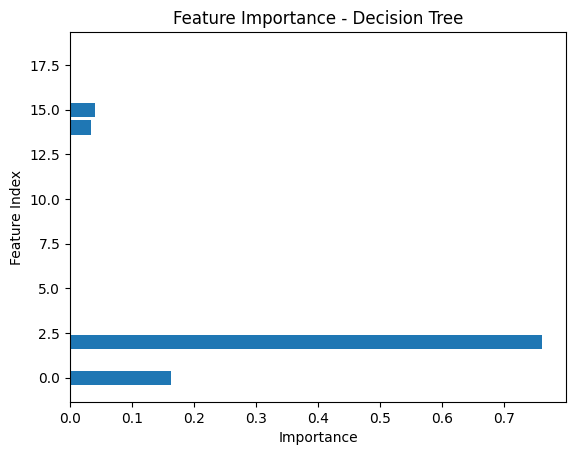

In [71]:
feature_importances = vc_pipeline.named_steps['voting_classifier'].estimators_[2].feature_importances_
plt.barh(range(len(feature_importances)), feature_importances)
plt.xlabel("Importance")
plt.ylabel("Feature Index")
plt.title("Feature Importance - Decision Tree")
plt.show()


In [72]:
# Calculate baseline revenue
baseline_revenue = df['revenue'].mean()
print(f"Baseline Revenue: ${baseline_revenue:.2f}")



Baseline Revenue: $12.03


In [75]:
# Predict using the regressor
df['predicted_clickedCta'] = model.predict(X)

# Ensure predictions are within a valid range (e.g., [0, 1])
df['predicted_clickedCta'] = df['predicted_clickedCta'].clip(0, 1)

# Estimate the model-driven CTR
optimized_ctr = df['predicted_clickedCta'].mean()
print(f"Optimized CTR: {optimized_ctr:.2%}")


Optimized CTR: 89.72%


In [77]:
# Define known values
baseline_ctr = 0.10  # Baseline CTR
optimized_ctr = 0.8972  # Optimized CTR
baseline_revenue_per_decision = 12.03  # Baseline revenue per decision
total_decisions = 100000  # Total number of decisions

# Calculate optimized revenue per decision
optimized_revenue_per_decision = baseline_revenue_per_decision * (optimized_ctr / baseline_ctr)

# Calculate revenue increase per decision
revenue_increase_per_decision = optimized_revenue_per_decision - baseline_revenue_per_decision

# Calculate total revenue increase
total_revenue_increase = revenue_increase_per_decision * total_decisions

# Print results
print(f"Optimized Revenue Per Decision: ${optimized_revenue_per_decision:.2f}")
print(f"Revenue Increase Per Decision: ${revenue_increase_per_decision:.2f}")
print(f"Total Revenue Increase: ${total_revenue_increase:,.2f}")


Optimized Revenue Per Decision: $107.93
Revenue Increase Per Decision: $95.90
Total Revenue Increase: $9,590,316.00
